In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker, cm


from scipy import optimize

In [2]:
class Rosenbrock:
    name = "Rosenbrock"
    area = np.asarray([[-2.0, 2.0], [-1.0, 3.0]])
    min = np.asarray([[1.0, 1.0]])
    
    def objective(x):
        return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

In [3]:
class Beale:
    name = "Beale"
    area = np.asarray([[-4.5, 4.5], [-4.5, 4.5]])
    min = np.asarray([[3, 0.5]])
    
    def objective(xy):
        x = xy[0]
        y = xy[1]
        return (1.5 - x + x * y)**2 + (2.25 - x + x * y**2)**2 + (2.625 - x + x * y**3)**2


In [4]:
class GoldsteinPrice:
    name = "GoldsteinPrice"
    area = np.asarray([[-2.0, 2.0], [-2.0, 2.0]])
    min = np.asarray([[0.0, -1.0]])
    
    def objective(xl):
        x = xl[0]
        y = xl[1]
        t1 = (x + y + 1)**2
        t2 = 19 - 14 * x + 3 * x**2 - 14 * y + 6 * x * y + 3 * y**2
        t3 = (2 * x - 3 * y)**2
        t4 = 18 - 32 * x + 12 * x**2 + 48 * y - 36 * x * y + 27 * y**2
        return (1 + t1 * t2) * (30 + t3 * t4)

In [5]:
class Himmelblau:
    name = "Himmelblau"
    area = np.asarray([[-5.0, 5.0], [-5.0, 5.0]])
    min = np.asarray([[3.0, 2.0], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584428, -1.848126]])
    
    def objective(x):
        return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

In [6]:
i = 0
class Particle:
    def __init__(self, objective, area, a_ind, a_grp, w, max_deg):
        global i
        self.id = i
        i = i+1
        
        self.objective = objective
        self.area = area
        self.limits = np.swapaxes(area, 0, 1)

        self.w = w
        self.a_ind = a_ind #w * (np.random.rand(area.shape[0]) * 2.0 - np.ones(area.shape[0])) # np.random.rand()
        self.a_grp = a_grp
        self.max_deg = max_deg

        self.p = area[:, 0] + np.random.rand(area.shape[0]) * (area[:, 1] - area[:, 0])
        

        self.v = np.random.rand(self.area.shape[0]) * 2.0 - np.ones(self.area.shape[0])
        self.v = self.w * self.v / np.linalg.norm(self.v)

        self.p_best = self.p_best_neigh = self.p

        self.f_best = objective(self.p)
        self.f_best_neigh = self.f_best


    def update(self, r_grp): #i
        
        def random_rotation(r, max_degree):
            theta = np.deg2rad(max_degree) * (r - 0.5)
            return np.asarray([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
      
        r_ind = np.random.rand() # changes every iteration
        
        
        R_ind = random_rotation(r_ind, self.max_deg)
        R_grp = random_rotation(r_grp, self.max_deg)
        
        #print("id:", self.id, 
        #      "prior:", self.w * self.v,
        #      "ind:" , self.a_ind * r_ind * (self.p_best - self.p),
        #      "grp:" , self.a_grp * r_grp * (self.p_best_neigh - self.p))
        
        
        dir_p_best = (self.p_best - self.p)
        dir_p_best = dir_p_best / (1e-7 + np.linalg.norm(dir_p_best))
        
        dir_p_best_neigh = (self.p_best_neigh - self.p)
        dir_p_best_neigh = dir_p_best_neigh / (1e-7 + np.linalg.norm(dir_p_best_neigh))
        
        self.v = (self.w * self.v
                + self.a_ind * R_ind @ dir_p_best
                + self.a_grp * R_grp @ dir_p_best_neigh
                )
        
        #self.v = (self.w * self.v
        #        + self.a_ind * r_ind * (self.p_best - self.p)
        #        + self.a_grp * r_grp * (self.p_best_neigh - self.p)
        #        )
        
        self.p += self.v
        self.p = np.clip(self.p, self.limits[0], self.limits[1])
        
        
        #print("pos:", self.p)
   
    def eval(self):
        f = self.objective(self.p)
        if f < self.f_best: # <, >
            self.p_best = np.copy(self.p)
            self.f_best = np.copy(f)
        if f < self.f_best_neigh: # <, >
            self.p_best_neigh = np.copy(self.p)
            self.f_best_neigh = np.copy(f)
        return self.p, f

In [7]:
#p = np.array([-5, 8])
#area = np.array([[-1, 1], [-1, 7]])
#limits = np.swapaxes(area, 0, 1)
#p = np.clip(p, limits[0], limits[1])
#print(p)

In [8]:
def particle_swarm_optimization(m, objective, area, iterations, w, max_deg):
    tmp = np.min(np.diff(area, axis=1))
    
    a_ind = 0.1 * tmp # w #np.random.rand()
    a_grp = 0.1 * tmp # np.random.rand() 
    
    
    particles = [Particle(objective, area, a_ind, a_grp, w, max_deg) for _ in range(m)]
    
    p_best_neigh = particles[0].p_best
    f_best_neigh = particles[0].f_best
    for particle in particles:
        if particle.f_best < f_best_neigh: # <, >
            p_best_neigh = particle.p_best_neigh
            f_best_neigh = particle.f_best_neigh

    history = np.zeros((m, iterations, area.shape[0]))
    
    for i in range(1, iterations):
        for j, particle in enumerate(particles):
            particle.p_best_neigh = p_best_neigh
            particle.f_best_neigh = f_best_neigh
            
            r_grp = np.random.rand()
            particle.update(r_grp)
            p, f = particle.eval()
            history[j, i] = p
            if f < f_best_neigh: # <, >
                p_best_neigh = np.copy(p) # <---
                f_best_neigh = np.copy(f) # <---
                #history = np.concatenate((history, [p_best_neigh]), axis=0) # <---
    return p_best_neigh, f_best_neigh, history

In [9]:
np.random.seed(7777879) # randomize seed

# define testfunction, objective, area
test_function = Beale

objective = test_function.objective
area = test_function.area
min = test_function.min

iterations = 50
m = 17
w = 0.9
max_deg = 10

p_best, f_best, history = particle_swarm_optimization(m, objective, area, iterations, w, max_deg)

In [10]:
history.shape

(17, 50, 2)

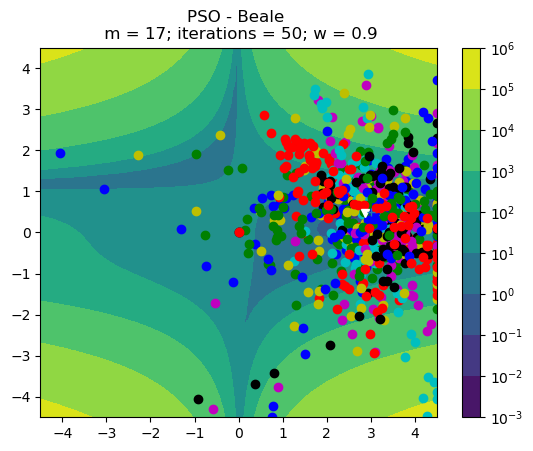

In [11]:
resolution = 100
xlist = np.linspace(area[0, 0], area[0, 1], resolution)
ylist = np.linspace(area[1, 0], area[1, 1], resolution)
X, Y = np.meshgrid(xlist, ylist)
I = np.stack([X, Y], axis=-1)

Z = np.zeros((resolution, resolution))
Z = np.apply_along_axis(objective, -1, I)

fig , ax = plt.subplots(1,1)

cp = ax.contourf(X, Y, Z, locator=ticker.LogLocator(), levels = 100)
fig.colorbar(cp) # Add a colorbar to a plot
'''
    b: blue
    g: green
    r: red
    c: cyan
    m: magenta
    y: yellow
    k: black
    w: white
'''
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, particle_h in enumerate(history):
    ax.plot(*particle_h.T, 'o', color = colors[i % len(colors)])
    #ax.quiver(particle_h.T[0], 
    #          particle_h.T[1], 
    #          np.diff(particle_h.T[0], prepend = particle_h.T[0][0]), 
    #          np.diff(particle_h.T[1], prepend = particle_h.T[1][0]),
    #          color = colors[i % len(colors)]
    #          )
ax.plot(p_best[0], p_best[1], 'v', color='white')
for el in min:
    ax.plot(el[0], el[1], '+')
ax.set_title(f'PSO - {test_function.name} \n m = {m}; iterations = {iterations}; w = {w}')
plt.show()

In [12]:
p_best,f_best

(array([2.87563266, 0.46878213]), array(0.00288105))

In [13]:
history

array([[[ 0.        ,  0.        ],
        [ 2.01022442,  2.45998616],
        [ 3.00622114,  1.43291728],
        ...,
        [ 3.09281629,  1.32479157],
        [ 3.1670382 ,  1.19027085],
        [ 2.60685384, -0.61764304]],

       [[ 0.        ,  0.        ],
        [ 4.5       , -1.8530921 ],
        [ 4.15697715, -0.31921588],
        ...,
        [ 2.65183117,  1.08854599],
        [ 3.16546857,  0.56573998],
        [ 2.78799276, -0.22854505]],

       [[ 0.        ,  0.        ],
        [ 2.73476126,  0.13361012],
        [ 3.43069723, -0.08344778],
        ...,
        [ 3.91245397, -0.73572188],
        [ 4.5       , -1.07213864],
        [ 3.85194072, -0.11645681]],

       ...,

       [[ 0.        ,  0.        ],
        [-0.73570275, -0.81501426],
        [ 1.42970219, -1.08452023],
        ...,
        [ 2.1678303 , -0.10306121],
        [ 3.52919615,  0.88028089],
        [ 3.38437845,  0.61092392]],

       [[ 0.        ,  0.        ],
        [ 2.75531108,  1.97

In [14]:
idx = np.linalg.norm(min - p_best, axis = 1).argmin()
print(np.linalg.norm(min[idx] - p_best))

0.1282255437252567
